# Dual auto-encoder workflow idea for generating invasion probability (idea credit: Niels Billiet)

In [ ]:
# import dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from captum.attr import IntegratedGradients
from sklearn.metrics import roc_auc_score

print("All dependencies imported successfully.")

All dependencies imported successfully.


# 1. Generate some species and country characteristics data

In [6]:
# ==========================================
# 1. DATA GENERATION (Synthetic Dataset)
# ==========================================
np.random.seed(42)
n_species = 100
n_countries = 50

# Species traits (10 features) with 20% missing values
s_data = np.random.randn(n_species, 10)
mask = np.random.choice([True, False], size=s_data.shape, p=[0.2, 0.8])
s_data[mask] = np.nan

# Country traits (8 features)
c_data = np.random.randn(n_countries, 8)

# Dummy labels for training the predictor
# (In real life, this is your historical record of which species invaded where)
n_train_samples = 500
train_species_idx = np.random.randint(0, n_species, n_train_samples)
train_country_idx = np.random.randint(0, n_countries, n_train_samples)
# Label is 1 if traits align, else 0
y_train = (np.random.rand(n_train_samples) > 0.5).astype(float)

# 2. Pre-process data by filling NAs and scaling data

In [7]:
# ==========================================
# 2. PRE-PROCESSING
# ==========================================
# Fill NaNs with mean and scale
s_mean = np.nanmean(s_data, axis=0)
s_filled = np.where(np.isnan(s_data), s_mean, s_data)

scaler_s = StandardScaler()
scaler_c = StandardScaler()

X_s_tensor = torch.FloatTensor(scaler_s.fit_transform(s_filled))
X_c_tensor = torch.FloatTensor(scaler_c.fit_transform(c_data))
Y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)

# 3. Create the auto-encoder models for both (denoised) species traits and country traits, as well as the invasion probability predictor

In [8]:
# ==========================================
# 3. MODEL ARCHITECTURES
# ==========================================
class DenoisingSpeciesAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def forward(self, x):
        noise = torch.randn_like(x) * 0.1
        z = self.encoder(x + noise)
        return z, self.decoder(z)

class CountryAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        return z, self.decoder(z)

class InvasionPredictor(nn.Module):
    def __init__(self, s_enc, c_enc, s_lat, c_lat):
        super().__init__()
        self.s_enc = s_enc
        self.c_enc = c_enc
        self.classifier = nn.Sequential(
            nn.Linear(s_lat + c_lat, 16), nn.ReLU(),
            nn.Linear(16, 1), nn.Sigmoid()
        )
    def forward(self, s, c):
        return self.classifier(torch.cat((self.s_enc(s), self.c_enc(c)), dim=1))

# 4. Train the models

In [9]:
# ==========================================
# 4. TRAINING PIPELINE
# ==========================================
LATENT_DIM = 4
spec_ae = DenoisingSpeciesAE(10, LATENT_DIM)
coun_ae = CountryAE(8, LATENT_DIM)

# Step A: Pre-train AEs
def train_ae(model, data):
    opt = optim.Adam(model.parameters(), lr=0.01)
    for _ in range(100):
        z, rec = model(data)
        loss = nn.MSELoss()(rec, data)
        opt.zero_grad(); loss.backward(); opt.step()

train_ae(spec_ae, X_s_tensor)
train_ae(coun_ae, X_c_tensor)

# Step B: Train Predictor
predictor = InvasionPredictor(spec_ae.encoder, coun_ae.encoder, LATENT_DIM, LATENT_DIM)
opt_p = optim.Adam(predictor.parameters(), lr=0.01)

for _ in range(200):
    # Training on a subset of known interactions
    p_out = predictor(X_s_tensor[train_species_idx], X_c_tensor[train_country_idx])
    loss = nn.BCELoss()(p_out, Y_train_tensor)
    opt_p.zero_grad(); loss.backward(); opt_p.step()

# 5. Evaluate model performance

In [ ]:
# ==========================================
# 5. EVALUATE MODEL PERFORMANCE
# ==========================================

def validate_by_country(X_s, X_c, labels, train_indices, country_names):
    """
    Performs validation by holding out one country at a time.
    """
    unique_countries = np.unique(train_country_idx)
    scores = []

    for country_id in unique_countries:
        # Create masks for 'seen' vs 'unseen' countries
        test_mask = (train_country_idx == country_id)
        train_mask = ~test_mask
        
        # Split data
        # Note: We use the same pre-trained AEs
        predictor_loocv = InvasionPredictor(spec_ae.encoder, coun_ae.encoder, LATENT_DIM, LATENT_DIM)
        optimizer = optim.Adam(predictor_loocv.parameters(), lr=0.01)
        
        # Train on all countries EXCEPT country_id
        for epoch in range(100):
            p_out = predictor_loocv(X_s[train_species_idx[train_mask]], X_c[train_country_idx[train_mask]])
            loss = nn.BCELoss()(p_out, Y_train_tensor[train_mask])
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
        # Predict on the HELD-OUT country
        predictor_loocv.eval()
        with torch.no_grad():
            test_preds = predictor_loocv(X_s[train_species_idx[test_mask]], X_c[train_country_idx[test_mask]])
            actuals = Y_train_tensor[test_mask]
            
            # AUC is a better metric for invasion than accuracy
            if len(torch.unique(actuals)) > 1: # Need both 0 and 1 to calc AUC
                score = roc_auc_score(actuals.numpy(), test_preds.numpy())
                scores.append(score)
                print(f"Country {country_id} ({country_names[country_id]}) Held-Out AUC: {score:.2f}")

    print(f"\nAverage Cross-Country Generalization (AUC): {np.mean(scores):.2f}")

# Run validation
validate_by_country(X_s_tensor, X_c_tensor, Y_train_tensor, train_country_idx, country_names)

Country 0 (Country_0) Held-Out AUC: 0.90
Country 1 (Country_1) Held-Out AUC: 1.00
Country 2 (Country_2) Held-Out AUC: 0.98
Country 3 (Country_3) Held-Out AUC: 1.00
Country 4 (Country_4) Held-Out AUC: 1.00
Country 5 (Country_5) Held-Out AUC: 1.00
Country 6 (Country_6) Held-Out AUC: 1.00
Country 7 (Country_7) Held-Out AUC: 1.00
Country 8 (Country_8) Held-Out AUC: 1.00
Country 9 (Country_9) Held-Out AUC: 0.92
Country 10 (Country_10) Held-Out AUC: 0.93
Country 11 (Country_11) Held-Out AUC: 0.93
Country 12 (Country_12) Held-Out AUC: 1.00
Country 13 (Country_13) Held-Out AUC: 1.00
Country 14 (Country_14) Held-Out AUC: 0.92
Country 15 (Country_15) Held-Out AUC: 1.00
Country 16 (Country_16) Held-Out AUC: 1.00
Country 17 (Country_17) Held-Out AUC: 1.00
Country 18 (Country_18) Held-Out AUC: 1.00
Country 19 (Country_19) Held-Out AUC: 1.00
Country 20 (Country_20) Held-Out AUC: 1.00
Country 21 (Country_21) Held-Out AUC: 1.00
Country 22 (Country_22) Held-Out AUC: 1.00
Country 24 (Country_24) Held-Ou

# 6. Calculate all risks for all species in all countries


--- GLOBAL INVASION PROBABILITY LIST ---
Species_52    0.996486
Species_24    0.959832
Species_10    0.951759
Species_54    0.951376
Species_28    0.946169
Species_48    0.940967
Species_79    0.939940
Species_80    0.919997
Species_61    0.914849
Species_14    0.913191
Species_22    0.909019
Species_42    0.907544
Species_89    0.900008
Species_7     0.881953
Species_70    0.880000
Species_1     0.863811
Species_12    0.860374
Species_9     0.859770
Species_98    0.853326
Species_90    0.853300
dtype: float64


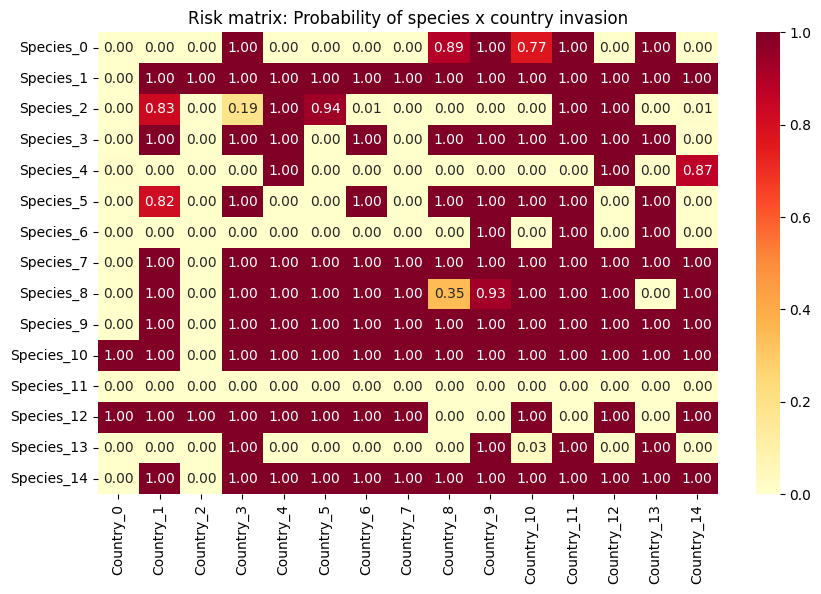

In [ ]:
# ==========================================
# 6. FINAL INFERENCE: THE RISK MATRIX 
# ==========================================

#currently on all, also the already invaded species x country pairs

predictor.eval()
with torch.no_grad():
    # Matrix of (N_Species x N_Countries)
    full_risk_matrix = np.zeros((n_species, n_countries))
    for i in range(n_species):
        # Repeat species i traits for all countries
        s_rep = X_s_tensor[i].unsqueeze(0).repeat(n_countries, 1)
        full_risk_matrix[i, :] = predictor(s_rep, X_c_tensor).squeeze().numpy()

# Format as DataFrame
species_names = [f"Species_{i}" for i in range(n_species)]
country_names = [f"Country_{j}" for j in range(n_countries)]
df_risk = pd.DataFrame(full_risk_matrix, index=species_names, columns=country_names)

# Output: Mean probability for all species
print("\n--- GLOBAL INVASION PROBABILITY LIST ---")
species_summary = df_risk.mean(axis=1).sort_values(ascending=False)
print(species_summary.head(20)) # Top 20 most invasive species

# Visualize
plt.figure(figsize=(10, 6))
sns.heatmap(df_risk.iloc[:15, :15], annot=True, fmt=".2f",cmap="YlOrRd")
plt.title("Risk matrix: Probability of species x country invasion")
plt.show()

# 7. Evaluate importance of different country and species traits for making risk predictions

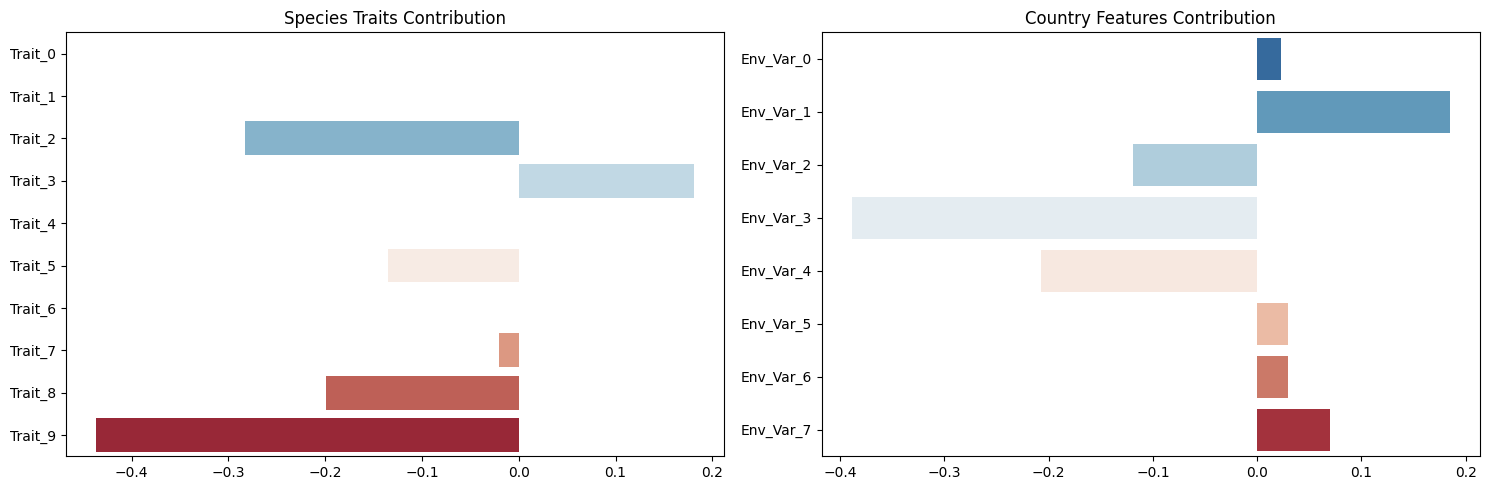

In [ ]:
#Attribution workflow (full model)

def explain_prediction(species_idx, country_idx, predictor, X_s, X_c, s_cols, c_cols):
    predictor.eval()
    
    def model_forward(s_input, c_input):
        return predictor(s_input, c_input)

    ig = IntegratedGradients(model_forward)
    s_input = X_s[species_idx].unsqueeze(0)
    c_input = X_c[country_idx].unsqueeze(0)
    
    attr_s, attr_c = ig.attribute((s_input, c_input), target=0)
    
    s_importance = attr_s.squeeze().numpy()
    c_importance = attr_c.squeeze().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Updated Seaborn syntax to avoid FutureWarnings
    sns.barplot(x=s_importance, y=s_cols, ax=ax1, hue=s_cols, palette="RdBu_r", legend=False)
    ax1.set_title(f"Species Traits Contribution")
    
    sns.barplot(x=c_importance, y=c_cols, ax=ax2, hue=c_cols, palette="RdBu_r", legend=False)
    ax2.set_title(f"Country Features Contribution")
    
    plt.tight_layout()
    plt.show()
    
# Example usage (assuming you have column name lists)
s_feature_names = [f"Trait_{i}" for i in range(10)]
c_feature_names = [f"Env_Var_{i}" for i in range(8)]

# Explain the 1st species in the 1st country
explain_prediction(0, 0, predictor, X_s_tensor, X_c_tensor, s_feature_names, c_feature_names)

Country 0 (Country_0) Held-Out AUC: 0.57
Country 1 (Country_1) Held-Out AUC: 0.79
Country 2 (Country_2) Held-Out AUC: 0.77
Country 3 (Country_3) Held-Out AUC: 0.50
Country 4 (Country_4) Held-Out AUC: 0.60
Country 5 (Country_5) Held-Out AUC: 0.93
Country 6 (Country_6) Held-Out AUC: 0.92
Country 7 (Country_7) Held-Out AUC: 0.83
Country 8 (Country_8) Held-Out AUC: 0.96
Country 9 (Country_9) Held-Out AUC: 0.96
Country 10 (Country_10) Held-Out AUC: 0.79
Country 11 (Country_11) Held-Out AUC: 0.73
Country 12 (Country_12) Held-Out AUC: 1.00
Country 13 (Country_13) Held-Out AUC: 0.40
Country 14 (Country_14) Held-Out AUC: 0.94
Country 15 (Country_15) Held-Out AUC: 1.00
Country 16 (Country_16) Held-Out AUC: 1.00
Country 17 (Country_17) Held-Out AUC: 0.55
Country 18 (Country_18) Held-Out AUC: 0.96
Country 19 (Country_19) Held-Out AUC: 0.78
Country 20 (Country_20) Held-Out AUC: 0.91
Country 21 (Country_21) Held-Out AUC: 0.93
Country 22 (Country_22) Held-Out AUC: 1.00
Country 24 (Country_24) Held-Ou

In [11]:
# ==========================================
# 7. PREDICT ON NEW DATA (example)
# ==========================================
def predict_invasion_risk(new_species_raw, new_country_raw):
    """
    new_species_raw: np.array of traits (can contain NaNs)
    new_country_raw: np.array of country traits
    """
    predictor.eval()
    with torch.no_grad():
        # 1. Handle Species: Fill NaNs with training mean and scale
        s_filled = np.nan_to_num(new_species_raw, nan=s_mean)
        s_scaled = scaler_s.transform(s_filled.reshape(1, -1))
        s_tensor = torch.FloatTensor(s_scaled)
        
        # 2. Handle Country: Scale the new country data
        c_scaled = scaler_c.transform(new_country_raw.reshape(1, -1))
        c_tensor = torch.FloatTensor(c_scaled)
        
        # 3. Predict
        probability = predictor(s_tensor, c_tensor)
        
    return probability.item()

# Example: Predicting for a new country with random traits
new_country_traits = np.random.randn(8) 
new_species_traits = s_data[0] # Using an existing species

prob = predict_invasion_risk(new_species_traits, new_country_traits)
print(f"Risk for New Country: {prob:.2%}")

Risk for New Country: 96.57%
